# Multiclass logistic regression with gluon

In [1]:
from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import gluon
from tqdm import tqdm

## Context

In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

## MNIST Dataset

In [3]:
batch_size = 64
num_inputs = 784
num_outputs = 10
num_examples = 60000

In [4]:
def transform(data, label):
    return data.astype(np.float32) / 255, label.astype(np.float32)

In [5]:
train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True, 
                                                           transform=transform),
                                   batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=False, 
                                                          transform=transform),
                                  batch_size, shuffle=False)

## Mutliclass Logistic Regression

In [6]:
net = gluon.nn.Dense(num_outputs)

## Parameter Initialization

In [7]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

## Softmax Cross-Entropy Loss

In [8]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

## Optimizer

In [9]:
trainer = gluon.Trainer(params=net.collect_params(), 
                        optimizer='sgd', 
                        optimizer_params={'learning_rate': 0.1})

## Evaluation Function

In [10]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = mx.nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

## Accuracy - Randomly initialized network

In [11]:
evaluate_accuracy(test_data, net)

0.0774

## Training 

In [12]:
# Hyperparameters
epochs = 10
moving_loss = 0.

In [13]:
for e in tqdm(range(epochs)):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        with mx.autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += mx.nd.sum(loss).asscalar()

    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc: %s, Test_acc: %s" % (e, 
                                                               cumulative_loss / num_examples, 
                                                               train_accuracy, 
                                                               test_accuracy))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 0. Loss: 2.141845157019297, Train_acc: 0.7916833333333333, Test_acc: 0.8025


 10%|████████▎                                                                          | 1/10 [00:35<05:18, 35.33s/it]

Epoch 1. Loss: 0.9146137731234233, Train_acc: 0.8338166666666667, Test_acc: 0.843


 20%|████████████████▌                                                                  | 2/10 [01:10<04:41, 35.21s/it]

Epoch 2. Loss: 0.7461259582916896, Train_acc: 0.85135, Test_acc: 0.8576


 30%|████████████████████████▉                                                          | 3/10 [01:45<04:06, 35.23s/it]

Epoch 3. Loss: 0.6599271810730298, Train_acc: 0.86375, Test_acc: 0.8691


 40%|█████████████████████████████████▏                                                 | 4/10 [02:21<03:32, 35.34s/it]

Epoch 4. Loss: 0.6039995469371477, Train_acc: 0.8703666666666666, Test_acc: 0.876


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:58<02:58, 35.60s/it]

Epoch 5. Loss: 0.5632936976909637, Train_acc: 0.8758, Test_acc: 0.8809


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:33<02:22, 35.58s/it]

Epoch 6. Loss: 0.5326414702574412, Train_acc: 0.88, Test_acc: 0.8851


 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:08<01:46, 35.51s/it]

Epoch 7. Loss: 0.5081972484668096, Train_acc: 0.8840166666666667, Test_acc: 0.8865


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:44<01:11, 35.57s/it]

Epoch 8. Loss: 0.48769780044555666, Train_acc: 0.8867833333333334, Test_acc: 0.8878


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [05:19<00:35, 35.47s/it]

Epoch 9. Loss: 0.4706066422462463, Train_acc: 0.8899166666666667, Test_acc: 0.8923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:54<00:00, 35.44s/it]


## Visualize predictions

In [14]:
import matplotlib.pyplot as plt

In [15]:
# Prediction function
def model_predict(net,data):
    output = net(data.as_in_context(model_ctx))
    return mx.nd.argmax(output, axis=1)

In [16]:
# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(dataset=mx.gluon.data.vision.MNIST(train=False, 
                                                                          transform=transform),
                                       batch_size=10, shuffle=True)

(10, 28, 28, 1)


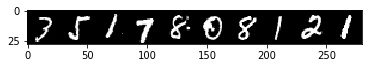

model predictions are: 
[9. 5. 1. 7. 8. 8. 8. 1. 2. 1.]
<NDArray 10 @cpu(0)>


In [17]:
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = mx.nd.transpose(data,(1, 0, 2, 3))
    im = mx.nd.reshape(im,(28, 10*28,1))
    imtiles = mx.nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break